In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import seaborn as sns
from sklearn.model_selection import KFold

2024-10-17 23:03:12.415607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 23:03:12.500270: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 23:03:12.524185: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 23:03:12.623711: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-17 23:03:14.051867: W tensorflow/compiler/tf2

In [3]:
weather_df = pd.read_csv("weather_data.csv")


weather_df['UV Index'] = pd.to_numeric(weather_df['UV Index'], errors='coerce')
print(weather_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13213 entries, 0 to 13212
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13169 non-null  float64
 1   Humidity              13178 non-null  float64
 2   Wind Speed            13175 non-null  float64
 3   Precipitation (%)     13180 non-null  float64
 4   Cloud Cover           13213 non-null  object 
 5   Atmospheric Pressure  13169 non-null  float64
 6   UV Index              13176 non-null  float64
 7   Season                13213 non-null  object 
 8   Visibility (km)       13166 non-null  float64
 9   Location              13213 non-null  object 
 10  Weather Type          13213 non-null  object 
 11  Irradiance            1333 non-null   float64
dtypes: float64(8), object(4)
memory usage: 1.2+ MB
None


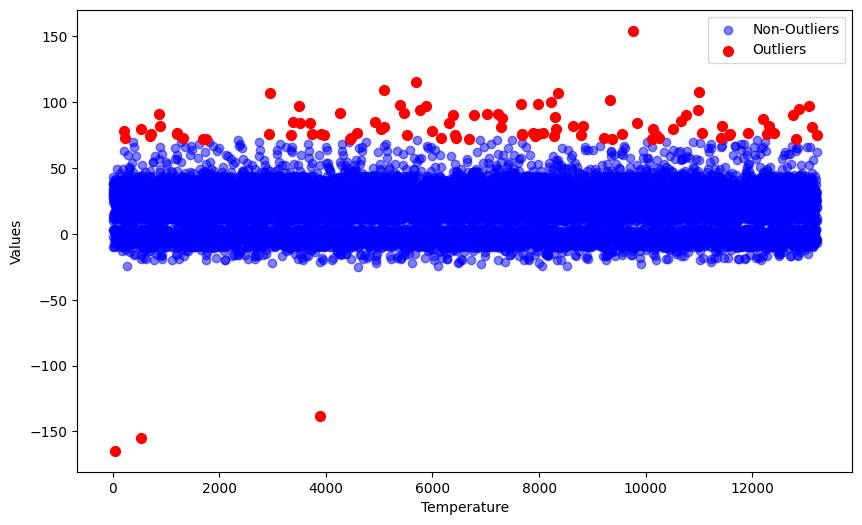

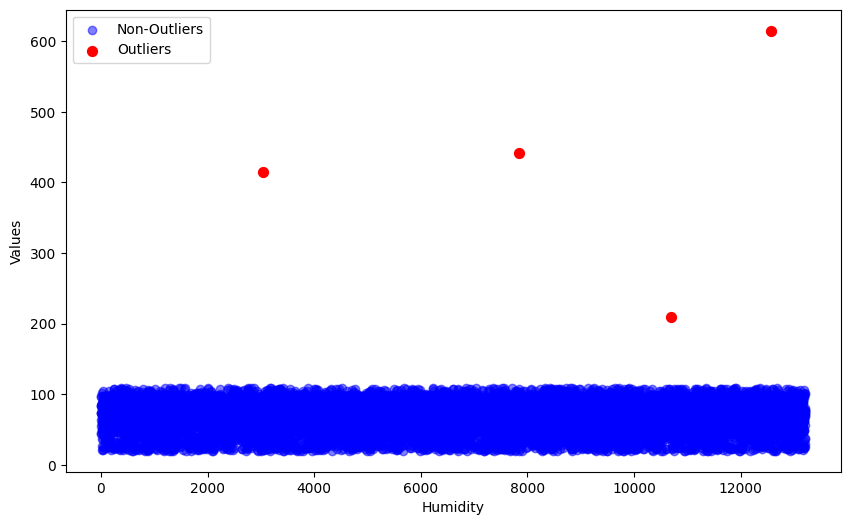

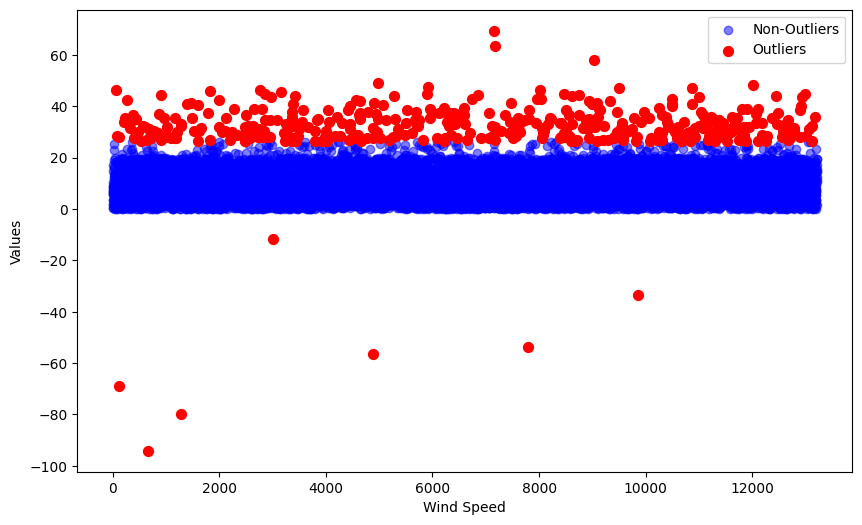

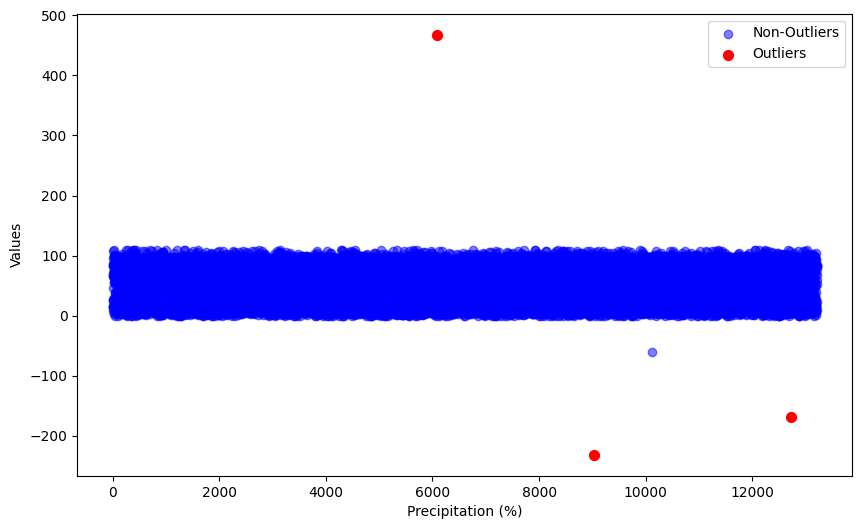

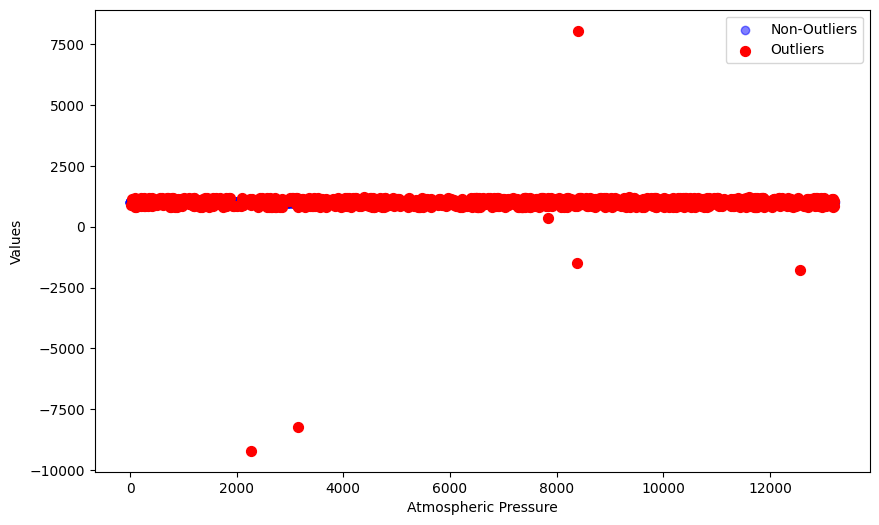

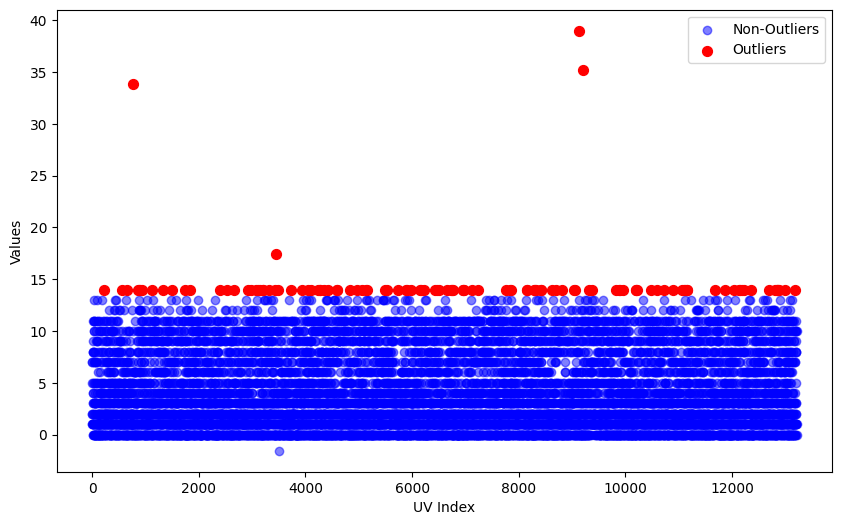

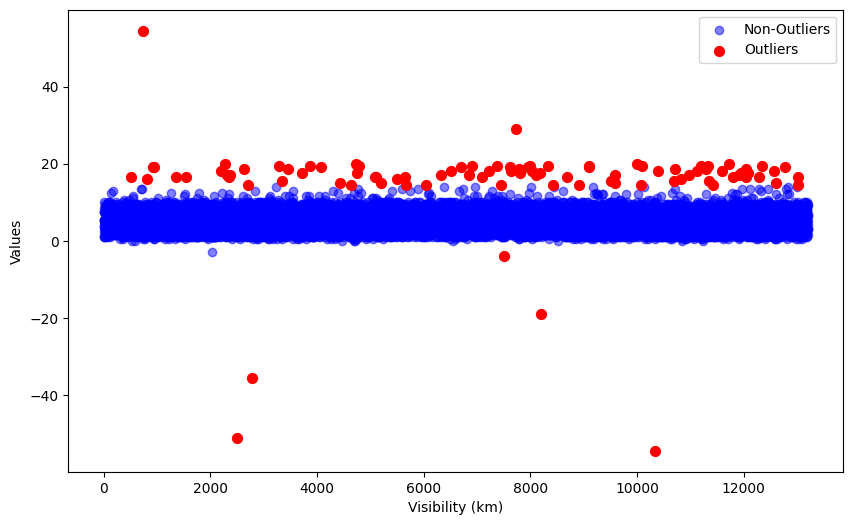

In [4]:
#detekcia a odstranenie outlierov kod z cvicenia
def detectOutliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

outlier_columns = ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)', 'Atmospheric Pressure','UV Index', 'Visibility (km)']

for column in outlier_columns:
    outliers = detectOutliers(weather_df, column)
    weather_df = weather_df.drop(outliers.index)
    
    plt.figure(figsize=(10,6))

    plt.scatter(weather_df.index, weather_df[column], color='blue', label='Non-Outliers', alpha=0.5)
    plt.scatter(outliers.index, outliers[column], color='red', label='Outliers', s=50)

    plt.xlabel(column)
    plt.ylabel("Values")
    plt.legend()
    plt.show()



In [5]:
nullValues = weather_df.isnull().sum()
duplicates = weather_df.duplicated().sum()
samples = weather_df.shape[0]

print(nullValues)
print("Null values total: ",nullValues.sum())
print("Duplicates:", duplicates)
print("Samples: ", samples)

Temperature                39
Humidity                   33
Wind Speed                 36
Precipitation (%)          29
Cloud Cover                 0
Atmospheric Pressure       42
UV Index                   33
Season                      0
Visibility (km)            39
Location                    0
Weather Type                0
Irradiance              10388
dtype: int64
Null values total:  10639
Duplicates: 11
Samples:  11560


In [6]:
#odstranenie stlpcov v ktorych je vela null hodnot, duplicit a null hodnot
weather_df_cleaned = weather_df.drop('Irradiance', axis=1)
weather_df_cleaned = weather_df_cleaned.dropna()
weather_df_cleaned = weather_df_cleaned.drop_duplicates()

nullValues = weather_df_cleaned.isnull().sum()
duplicates = weather_df_cleaned.duplicated().sum()
samples = weather_df_cleaned.shape[0]

print(nullValues)
print("Null values total: ",nullValues.sum())
print("Duplicates:", duplicates)
print("Samples: ", samples)


Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64
Null values total:  0
Duplicates: 0
Samples:  11300


In [7]:

weather_df.reset_index(drop=True, inplace=True)
one_hot_encoded_columns = ['Cloud Cover', 'Season', 'Location']
weather_df_cleaned_encoded = weather_df_cleaned.copy()
for column in one_hot_encoded_columns:
    one_hot_encoded = pd.get_dummies(weather_df_cleaned_encoded[column])
    weather_df_cleaned_encoded = pd.concat([weather_df_cleaned_encoded.drop(columns=column), one_hot_encoded.astype(int)], axis = 1)

label_encoder = LabelEncoder()
weather_df_cleaned_encoded['Weather Type'] = label_encoder.fit_transform(weather_df_cleaned_encoded['Weather Type'])




In [8]:
X = weather_df_cleaned_encoded.drop('Weather Type', axis=1)
Y = weather_df_cleaned_encoded['Weather Type']

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size = 0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp , Y_temp, test_size = 0.5, random_state=42)


X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((7910, 19), (7910,), (1695, 19), (1695,), (1695, 19), (1695,))

In [9]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)



model accuracy: 0.9634218289085545


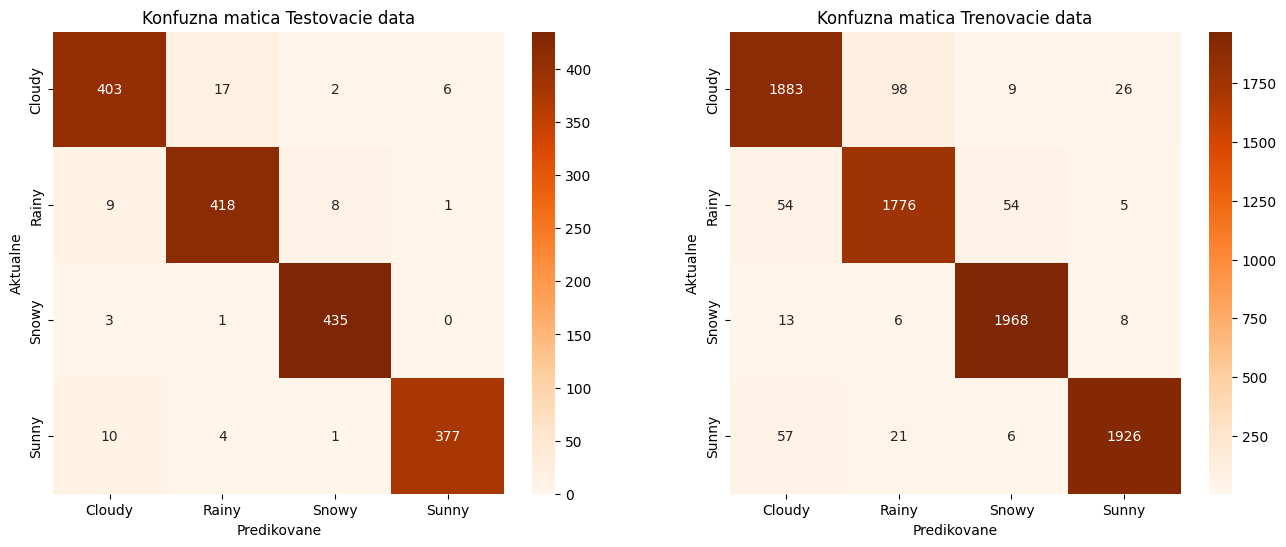

In [10]:
#logisticRegression
model = LogisticRegression(max_iter=200)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

accurracy = accuracy_score(Y_test, y_pred)
print(f"model accuracy: {accurracy}")

conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=['Cloudy', 'Rainy', 'Snowy', 'Sunny'], yticklabels=['Cloudy', 'Rainy', 'Snowy', 'Sunny'])
plt.title("Konfuzna matica Testovacie data")
plt.xlabel("Predikovane")
plt.ylabel("Aktualne")


conf_matrix = confusion_matrix(Y_train, y_pred_train)
plt.subplot(1,2,2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=['Cloudy', 'Rainy', 'Snowy', 'Sunny'], yticklabels=['Cloudy', 'Rainy', 'Snowy', 'Sunny'])
plt.title("Konfuzna matica Trenovacie data")
plt.xlabel("Predikovane")
plt.ylabel("Aktualne")
plt.show()

model accuracy: 0.9687315634218289


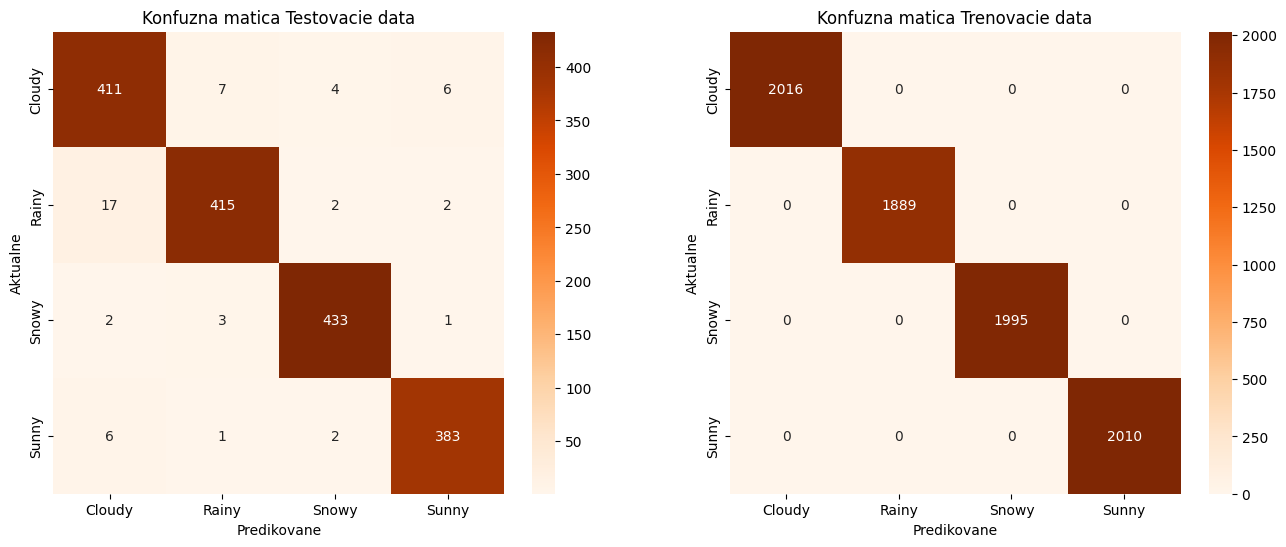

In [11]:
#DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

accurracy = accuracy_score(Y_test, y_pred)
print(f"model accuracy: {accurracy}")

conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=['Cloudy', 'Rainy', 'Snowy', 'Sunny'], yticklabels=['Cloudy', 'Rainy', 'Snowy', 'Sunny'])
plt.title("Konfuzna matica Testovacie data")
plt.xlabel("Predikovane")
plt.ylabel("Aktualne")


conf_matrix = confusion_matrix(Y_train, y_pred_train)
plt.subplot(1,2,2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=['Cloudy', 'Rainy', 'Snowy', 'Sunny'], yticklabels=['Cloudy', 'Rainy', 'Snowy', 'Sunny'])
plt.title("Konfuzna matica Trenovacie data")
plt.xlabel("Predikovane")
plt.ylabel("Aktualne")
plt.show()

model accuracy: 0.9646017699115044


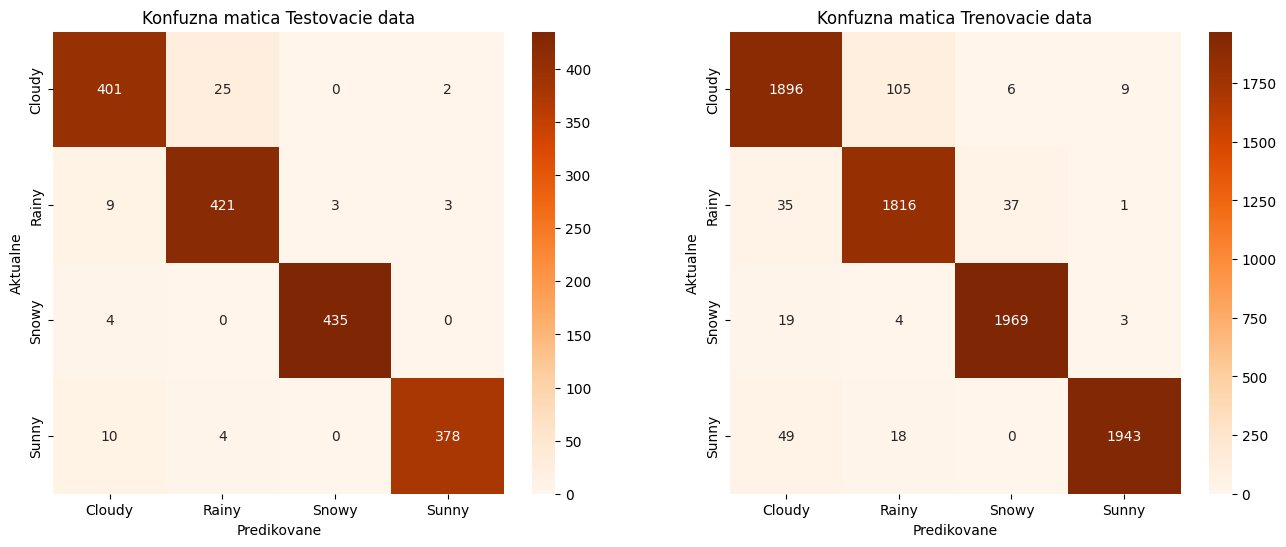

In [12]:
#KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

accurracy = accuracy_score(Y_test, y_pred)
print(f"model accuracy: {accurracy}")

conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=['Cloudy', 'Rainy', 'Snowy', 'Sunny'], yticklabels=['Cloudy', 'Rainy', 'Snowy', 'Sunny'])
plt.title("Konfuzna matica Testovacie data")
plt.xlabel("Predikovane")
plt.ylabel("Aktualne")


conf_matrix = confusion_matrix(Y_train, y_pred_train)
plt.subplot(1,2,2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=['Cloudy', 'Rainy', 'Snowy', 'Sunny'], yticklabels=['Cloudy', 'Rainy', 'Snowy', 'Sunny'])
plt.title("Konfuzna matica Trenovacie data")
plt.xlabel("Predikovane")
plt.ylabel("Aktualne")
plt.show()

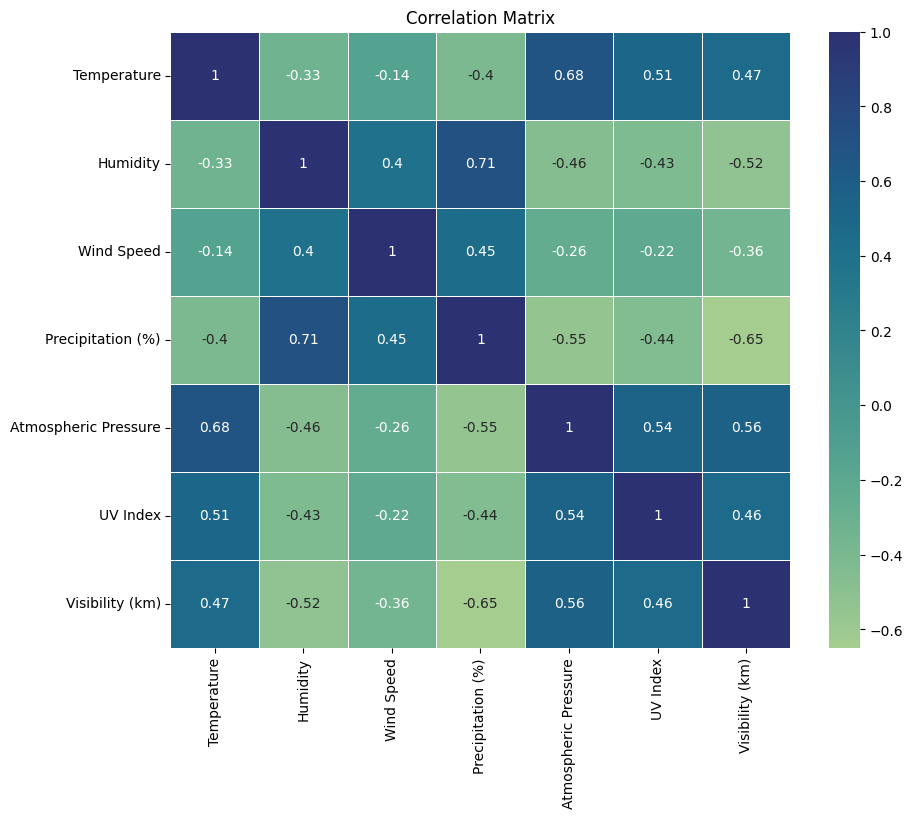

In [13]:
correlation_matrix = weather_df_cleaned.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='crest', linewidths=0.5).set(title="Correlation Matrix")
plt.show()

/tmp/ipykernel_5225/3185302277.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(temperature_by_season, x='Cloud Cover', y='Temperature', palette="crest").set(title="Average temperature by cloud cover", ylabel="Average Temperature")


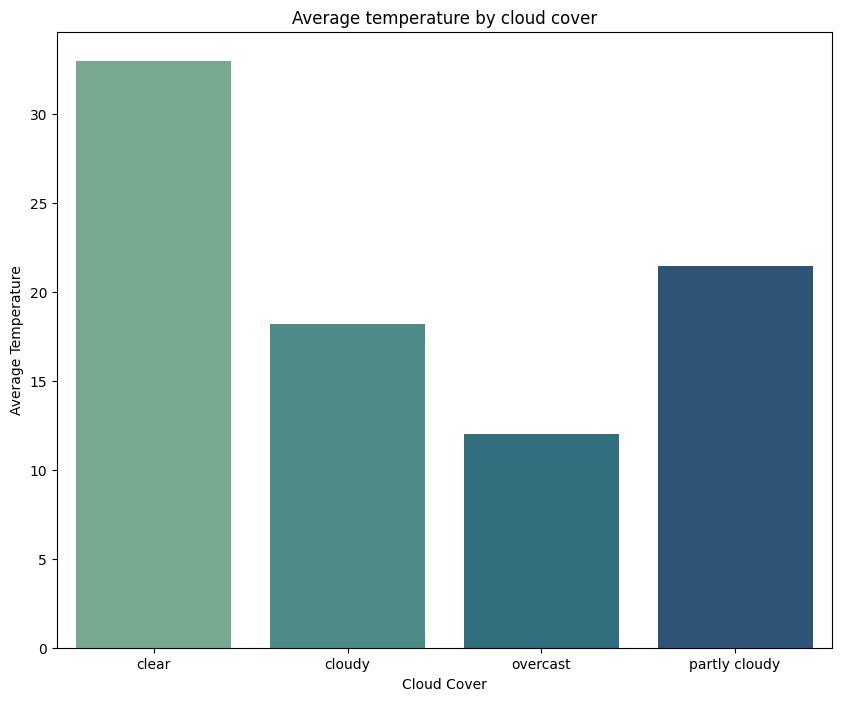

In [14]:
temperature_by_season = weather_df_cleaned.groupby('Cloud Cover')['Temperature'].mean().reset_index()

plt.figure(figsize=(10, 8))
sns.barplot(temperature_by_season, x='Cloud Cover', y='Temperature', palette="crest").set(title="Average temperature by cloud cover", ylabel="Average Temperature")
plt.show()

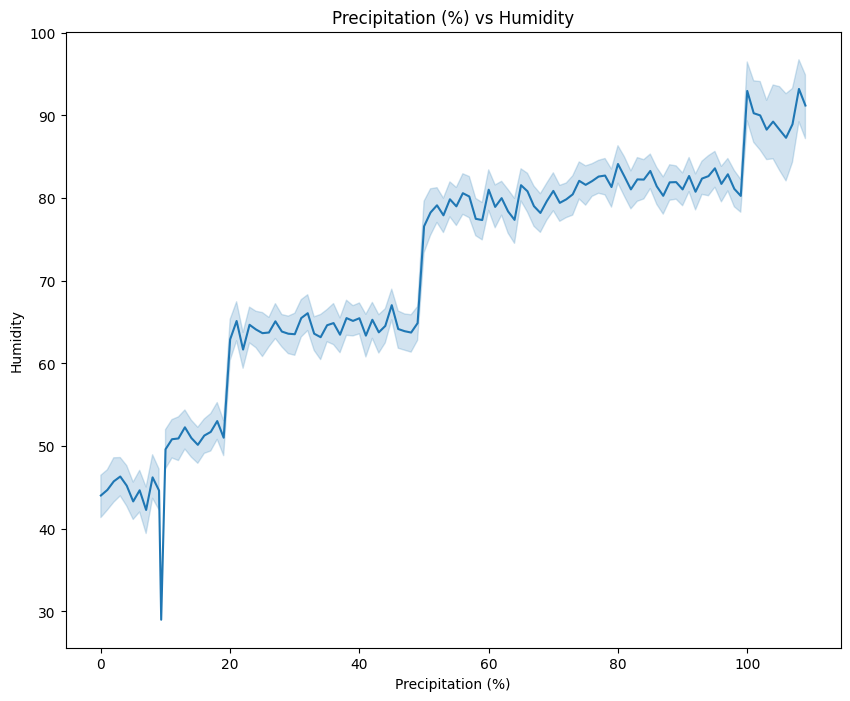

In [15]:
plt.figure(figsize=(10, 8))
sns.lineplot(weather_df_cleaned, x='Precipitation (%)', y='Humidity').set(title="Precipitation (%) vs Humidity")
plt.show()

<Figure size 1000x800 with 0 Axes>

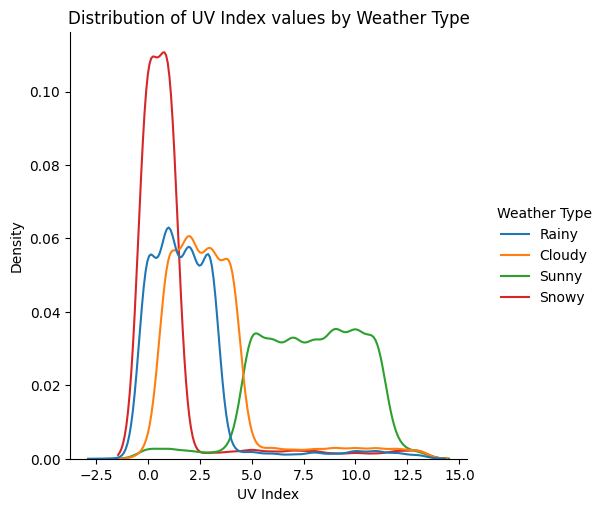

In [16]:
plt.figure(figsize=(10, 8))
sns.displot(weather_df_cleaned, x='UV Index', hue="Weather Type", kind="kde").set(title="Distribution of UV Index values by Weather Type")
plt.show()

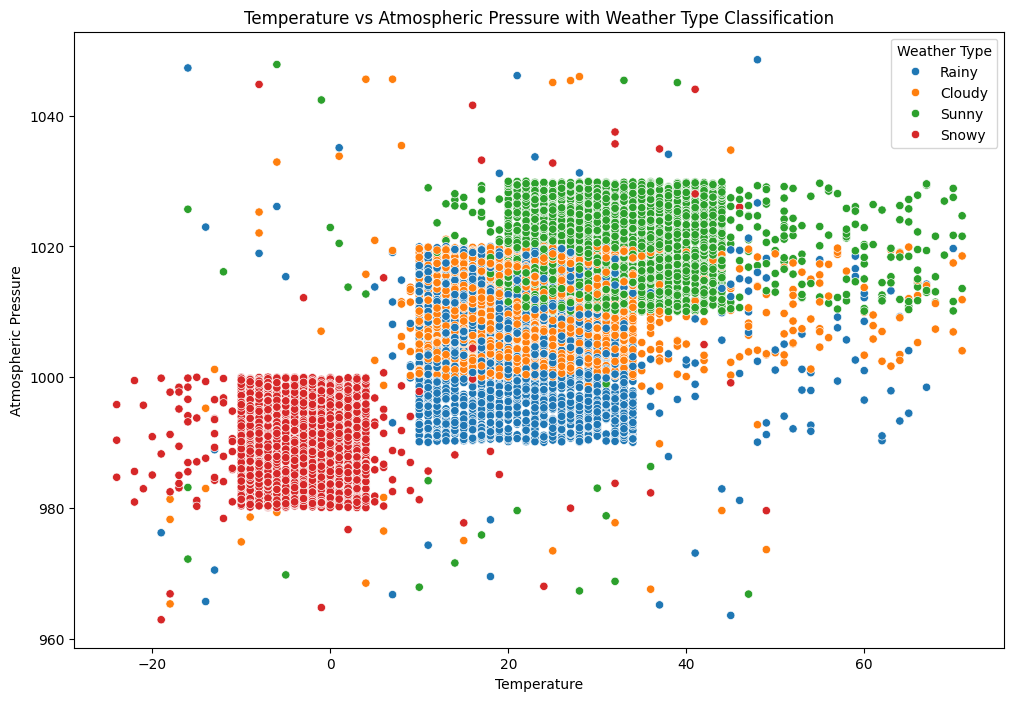

In [17]:
plt.figure(figsize=(12, 8))
sns.scatterplot(weather_df_cleaned, x='Temperature', y='Atmospheric Pressure', hue="Weather Type").set(title="Temperature vs Atmospheric Pressure with Weather Type Classification")
plt.show()

In [18]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(150, input_shape=(19,), activation='relu'))
model.add(tf.keras.layers.Dense(70, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, Y_train, epochs=400, batch_size=128, verbose=1, validation_data=(X_val, Y_val), callbacks=[early_stopping])

loss, accurracy = model.evaluate(X_test, Y_test)
train_loss, train_accurracy = model.evaluate(X_train, Y_train)
print(f'Test accuracy: {accurracy:.4f}')
print(f'Training accuracy: {train_accurracy:.4f}')

I0000 00:00:1729199001.717502    5225 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729199002.105810    5225 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729199002.105899    5225 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
/home/des/suns/env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1729199002.126053    5225 cuda_executor.cc:1001] could 

Num GPUs Available:  1


I0000 00:00:1729199002.126166    5225 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729199002.126211    5225 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729199002.408982    5225 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729199002.409315    5225 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-17 23:03:22.409341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2112] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.

Epoch 1/400


I0000 00:00:1729199004.194607    5320 service.cc:146] XLA service 0x7ff14c006a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729199004.194807    5320 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-10-17 23:03:24.229723: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-17 23:03:24.370547: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5963 - loss: 1.1323

I0000 00:00:1729199008.541344    5320 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.6115 - loss: 1.1026 - val_accuracy: 0.8637 - val_loss: 0.4638
Epoch 2/400
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8940 - loss: 0.3743 - val_accuracy: 0.9180 - val_loss: 0.2890
Epoch 3/400
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9278 - loss: 0.2452 - val_accuracy: 0.9363 - val_loss: 0.2425
Epoch 4/400
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9463 - loss: 0.2022 - val_accuracy: 0.9416 - val_loss: 0.2266
Epoch 5/400
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9565 - loss: 0.1820 - val_accuracy: 0.9434 - val_loss: 0.2137
Epoch 6/400
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9554 - loss: 0.1763 - val_accuracy: 0.9475 - val_loss: 0.2055
Epoch 7/400
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9568 - loss: 0.1549 - val_accuracy: 0.9493 - val_loss: 0.1930
Epoch 8/400
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9585 - loss: 0.1527 - val_accuracy: 0.9481 - val_loss: 

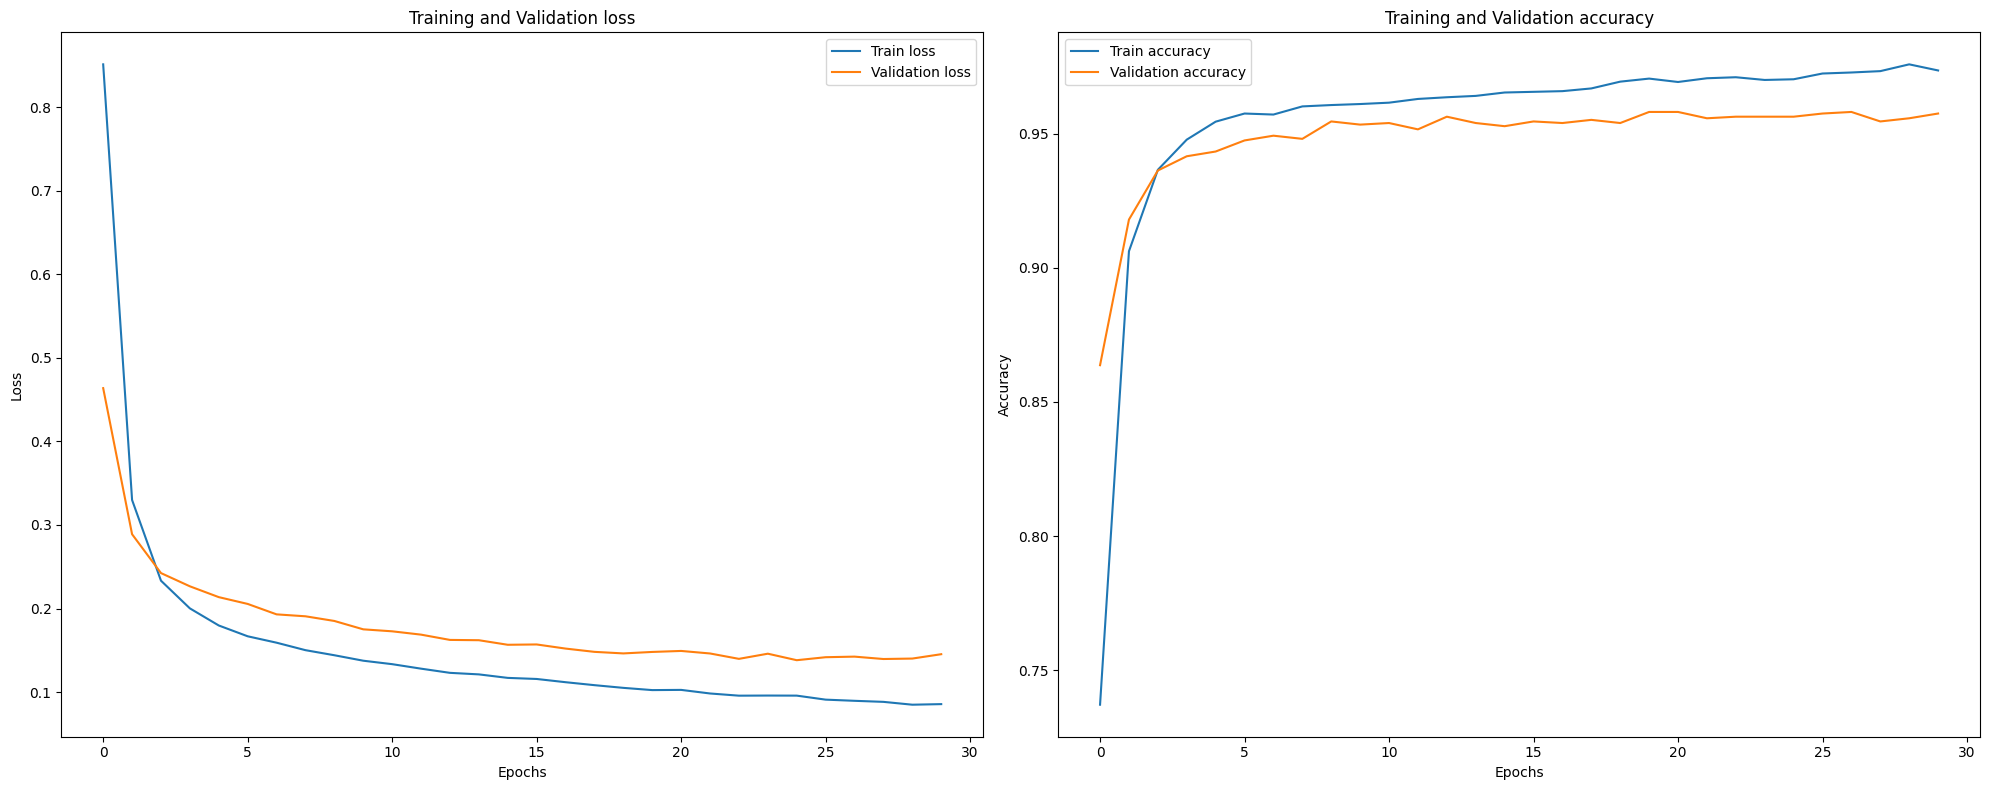

In [19]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], label="Train loss")
sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
sns.lineplot(x=range(len(history.history['accuracy'])), y=history.history['accuracy'], label="Train accuracy")
sns.lineplot(x=range(len(history.history['val_accuracy'])), y=history.history['val_accuracy'], label="Validation accuracy")
plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


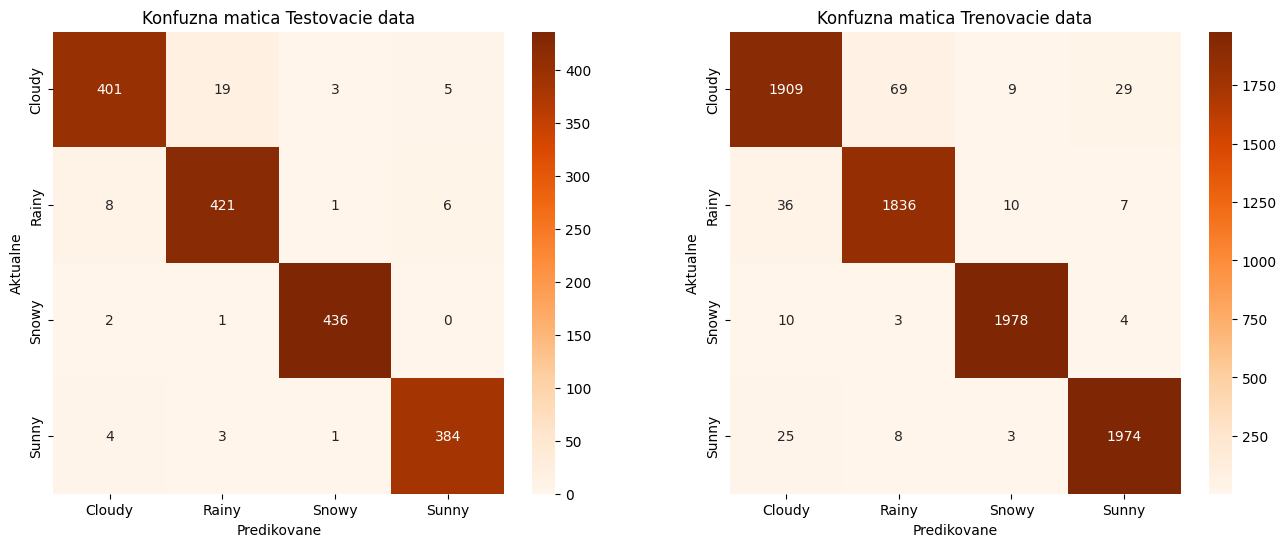

In [20]:

y_pred = np.argmax(model.predict(X_test), axis=1) 
#Y_test_conf =np.argmax(Y_test, axis=1)
conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=['Cloudy', 'Rainy', 'Snowy', 'Sunny'], yticklabels=['Cloudy', 'Rainy', 'Snowy', 'Sunny'])
plt.title("Konfuzna matica Testovacie data")
plt.xlabel("Predikovane")
plt.ylabel("Aktualne")


y_pred = np.argmax(model.predict(X_train), axis=1) 
#Y_train_conf =np.argmax(Y_train, axis=1)
conf_matrix = confusion_matrix(Y_train, y_pred)
plt.subplot(1,2,2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=['Cloudy', 'Rainy', 'Snowy', 'Sunny'], yticklabels=['Cloudy', 'Rainy', 'Snowy', 'Sunny'])
plt.title("Konfuzna matica Trenovacie data")
plt.xlabel("Predikovane")
plt.ylabel("Aktualne")
plt.show()

In [21]:
#N-fold cross validation
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
test_accuracies = []
train_accuracies = []
X.reset_index(drop=True, inplace=True)
Y.reset_index(drop=True, inplace=True)
X_scaled = scaler.fit_transform(X)
fold = 1
for train_index, val_index in kf.split(X_scaled):
    X_train_fold, X_val_fold = X_scaled[train_index], X_scaled[val_index]
    Y_train_fold, Y_val_fold = Y[train_index], Y[val_index]
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(300, input_shape=(19,), activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(4, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_fold, Y_train_fold, epochs=400, batch_size=128, verbose=1, validation_data=(X_val_fold, Y_val_fold), callbacks=[early_stopping])

    loss, accurracy = model.evaluate(X_val_fold, Y_val_fold)
    train_loss, train_accurracy = model.evaluate(X_train_fold, Y_train_fold)
    print(f'Validation accuracy: {accurracy:.4f}')
    print(f'Training accuracy: {train_accurracy:.4f}')

    test_accuracies.append(accurracy)
    train_accuracies.append(train_accurracy)

print(f'Average validation accuracy: {np.mean(test_accuracies):.4f}')
print(f'Average training accuracy: {np.mean(train_accuracies):.4f}')

Num GPUs Available:  1
Epoch 1/400


/home/des/suns/env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6583 - loss: 0.9522

2024-10-17 23:03:52.635250: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40', 36 bytes spill stores, 36 bytes spill loads

2024-10-17 23:03:52.912993: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40', 320 bytes spill stores, 320 bytes spill loads

2024-10-17 23:03:54.814495: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40', 84 bytes spill stores, 84 bytes spill loads

2024-10-17 23:03:55.340829: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40', 396 bytes spill stores, 396 bytes spill loads



71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.6599 - loss: 0.9483 - val_accuracy: 0.9111 - val_loss: 0.3209
Epoch 2/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9037 - loss: 0.3239 - val_accuracy: 0.9482 - val_loss: 0.2267
Epoch 3/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9304 - loss: 0.2434 - val_accuracy: 0.9540 - val_loss: 0.1976
Epoch 4/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9448 - loss: 0.2092 - val_accuracy: 0.9549 - val_loss: 0.1800
Epoch 5/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9427 - loss: 0.2024 - val_accuracy: 0.9531 - val_loss: 0.1615
Epoch 6/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9505 - loss: 0.1730 - val_accuracy: 0.9571 - val_loss: 0.1558
Epoch 7/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9545 - loss: 0.1629 - val_accuracy: 0.9597 - val_loss: 0.1425
Epoch 8/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9567 - loss: 0.1521 - val_accuracy: 0.9593 - val_loss: 0

2024-10-17 23:04:08.763223: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40', 36 bytes spill stores, 36 bytes spill loads



71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9721 - loss: 0.0891
283/283 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9779 - loss: 0.0624
Validation accuracy: 0.9699
Training accuracy: 0.9810
Epoch 1/400


/home/des/suns/env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.6528 - loss: 0.9681 - val_accuracy: 0.9199 - val_loss: 0.3226
Epoch 2/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9034 - loss: 0.3202 - val_accuracy: 0.9412 - val_loss: 0.2407
Epoch 3/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9286 - loss: 0.2508 - val_accuracy: 0.9487 - val_loss: 0.2065
Epoch 4/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9453 - loss: 0.1933 - val_accuracy: 0.9504 - val_loss: 0.1935
Epoch 5/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9457 - loss: 0.1978 - val_accuracy: 0.9496 - val_loss: 0.1848
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9188 - loss: 0.3282
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9140 - loss: 0.3115
Validation accuracy: 0.9199
Training accuracy: 0.9173
Epoch 1/400


/home/des/suns/env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.6412 - loss: 0.9665 - val_accuracy: 0.9146 - val_loss: 0.3006
Epoch 2/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9045 - loss: 0.3204 - val_accuracy: 0.9327 - val_loss: 0.2232
Epoch 3/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9279 - loss: 0.2542 - val_accuracy: 0.9438 - val_loss: 0.1849
Epoch 4/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9406 - loss: 0.2103 - val_accuracy: 0.9496 - val_loss: 0.1697
Epoch 5/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9495 - loss: 0.1887 - val_accuracy: 0.9580 - val_loss: 0.1547
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9139 - loss: 0.2987
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9171 - loss: 0.3006
Validation accuracy: 0.9146
Training accuracy: 0.9175
Epoch 1/400


/home/des/suns/env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.6512 - loss: 0.9806 - val_accuracy: 0.9058 - val_loss: 0.3320
Epoch 2/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9038 - loss: 0.3293 - val_accuracy: 0.9332 - val_loss: 0.2426
Epoch 3/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9320 - loss: 0.2480 - val_accuracy: 0.9372 - val_loss: 0.2109
Epoch 4/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9411 - loss: 0.2112 - val_accuracy: 0.9487 - val_loss: 0.1790
Epoch 5/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9499 - loss: 0.1831 - val_accuracy: 0.9513 - val_loss: 0.1659
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9063 - loss: 0.3199
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9084 - loss: 0.3138
Validation accuracy: 0.9058
Training accuracy: 0.9095
Epoch 1/400


/home/des/suns/env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6404 - loss: 0.9786 - val_accuracy: 0.9027 - val_loss: 0.3252
Epoch 2/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8966 - loss: 0.3319 - val_accuracy: 0.9434 - val_loss: 0.2358
Epoch 3/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9273 - loss: 0.2520 - val_accuracy: 0.9473 - val_loss: 0.2047
Epoch 4/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9398 - loss: 0.2277 - val_accuracy: 0.9544 - val_loss: 0.1837
Epoch 5/400
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9430 - loss: 0.1929 - val_accuracy: 0.9566 - val_loss: 0.1684
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8954 - loss: 0.3220
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9013 - loss: 0.3268
Validation accuracy: 0.9027
Training accuracy: 0.8986
Average validation accuracy: 0.9226
Average training accuracy: 0.9248
